In [1]:
import subprocess
import os
from Bio.Blast import NCBIWWW, NCBIXML
import pandas as pd
from Comparative_Analysis import Utilities as util
from tqdm.auto import tqdm
from Bio import Entrez, SeqIO, AlignIO, pairwise2, Align, Seq, motifs
from Bio.Seq import Seq
from Bio.SeqFeature import SeqFeature, FeatureLocation
from joblib import Parallel, delayed
import math
import seaborn as sns

In [2]:
project_dir = 'D:/Project_Data/Project_6'
genome_datasets_dir = project_dir + '/Datasets/NCBI_Datasets'
refseq_dir = 'D:/NCBI_Dataset_Mycobacteria'
output_dir = project_dir + '/Output'
reference_species = 'GCF_000195955.2'
num_cores = 16
core_numbers = list(range(1, num_cores+1))

##### Generate concatenated FASTA file for creating BLAST local database, together with dictionary of gene information

In [3]:
species_list = util.list_dirs(refseq_dir)
print(len(species_list))

205


In [4]:
def parse_genome(num_subsets, subset_num, id_list):
    ids = util.chunk_list(id_list, num_subsets, subset_num)
    temp = []
    for id in ids:
        temp_1 = []
        genome_record = next(SeqIO.parse(refseq_dir + '/' + id + '/genomic.gbff', "genbank"))
        organism_name = genome_record.annotations['organism']
        full_sequence = genome_record.seq
        for feature in genome_record.features:
            a = feature.qualifiers
            if feature.type == 'CDS':
                if a.get("protein_id") != None and a.get("locus_tag")!= None and a.get("translation")!= None:
                    locus_tag = a.get("locus_tag")[0]
                    protein_id = a.get("protein_id")[0]
                    translation = a.get("translation")[0]
                    temp_1.append([id, organism_name, int(feature.location.start), int(feature.location.end), int(feature.location.strand), locus_tag, protein_id, translation])
        if len(temp_1) > 1000:
            temp.append(temp_1)
    return temp

In [5]:
parallel_output = Parallel(n_jobs=-1)(delayed(parse_genome)(num_cores, core_number, species_list) for core_number in core_numbers)
temp = [item for sublist in parallel_output for item in sublist]
gene_records = [item for sublist in temp for item in sublist]
reference_gene_records = [x for x in gene_records if x[0] == reference_species]

In [6]:
gene_record_lookup_dict = {}
for record in gene_records:
    gene_record_lookup_dict[record[0]+'|'+record[6]] = (record[1], record[2], record[3], record[4], record[5])

In [7]:
def produce_blast_file(record_list, output_filename):
    with open(output_filename, 'w',  newline='') as outfile:
        line_length = 60
        for record in tqdm(record_list):
            sequence = record[7]
            lines = []
            sequence_length = len(sequence)
            number_of_lines = math.ceil(sequence_length / line_length)
            lines.append(">" +record[0]+'|'+record[6]+ "\n")
            for i in range(number_of_lines):
                subsequence = sequence[i*line_length:(i+1)*line_length]
                lines.append(subsequence + "\n")
            outfile.write(''.join(lines))

In [ ]:
produce_blast_file(gene_records, refseq_dir + '/all_myco_refseq.faa')
produce_blast_file(reference_gene_records, refseq_dir + '/reference_proteins.faa')

#### Build local blast database

In [ ]:
#  Run the followint commands - to do: put in subprocess
#  makeblastdb -in all_myco_refseq.faa -dbtype prot -out myco_refseq    
#  Then copy all files produced into /BLAST/myco_refseq folder
#  Then change diretory to be in this and run              blastp -query d:\NCBI_Dataset_Mycobacteria\reference_proteins.faa -db myco_refseq -out blast_results.xml -evalue 0.001 -outfmt 5 -num_threads 16 

In [ ]:
#w_d = os.getcwd()
#os.chdir("D:/")
#subprocess.run('cd d:\\BLAST\\nr & blastp -query d:\\Protein_'+ref+'.faa -db nr -out nick.xml -evalue 0.001 -outfmt 5 -num_threads 16', shell=True, capture_output = True)
#os.chdir(w_d)

In [8]:
blast_results_list = []
result_handle = open("D:\\BLAST\\myco_refseq\\blast_results.xml")
blast_records = NCBIXML.parse(result_handle)
for blast_record in blast_records:
    for alignment in blast_record.alignments:
        for hsp in alignment.hsps:
            blast_results_list.append([blast_record.query, alignment.title, alignment.accession, alignment.length, hsp.expect, hsp.identities, hsp.query_start, hsp.query_end, hsp.sbjct_start, hsp.sbjct_end, hsp.strand, hsp.score])

In [94]:
blast_results_TB_genes_df = pd.DataFrame(blast_results_list, columns = ['query', 'title', 'accession', 'length', 'e_value', 'identities', 'query_start', 'query_end', 'subject_start','subject_end','subject_strand', 'score'])

In [95]:
blast_results_TB_genes_df[['ref_1','ref_2']] = blast_results_TB_genes_df['title'].str.split(' ', expand=True,)
blast_results_TB_genes_df['info']=  blast_results_TB_genes_df['ref_2'].map(gene_record_lookup_dict)
blast_results_TB_genes_df[['organism', 'start', 'end', 'strand', 'locus_tag']] = pd.DataFrame(blast_results_TB_genes_df['info'].tolist(), index=blast_results_TB_genes_df.index)
blast_results_TB_genes_df['q_info']=  blast_results_TB_genes_df['query'].map(gene_record_lookup_dict)
blast_results_TB_genes_df[['q_organism', 'q_start', 'q_end', 'q_strand', 'q_locus_tag']] = pd.DataFrame(blast_results_TB_genes_df['q_info'].tolist(), index=blast_results_TB_genes_df.index)

In [96]:
blast_results_TB_genes_df = blast_results_TB_genes_df.loc[blast_results_TB_genes_df.groupby(['organism','query'])['score'].idxmax()]
blast_results_TB_genes_df = blast_results_TB_genes_df.loc[blast_results_TB_genes_df.groupby(['ref_2'])['score'].idxmax()]
blast_results_TB_genes_df = blast_results_TB_genes_df.sort_values(['organism','q_start'])    #sort by target organisms
blast_results_TB_genes_df['q_order_previous_locus_tag']=blast_results_TB_genes_df['locus_tag'].shift(1)
blast_results_TB_genes_df['q_order_next_locus_tag']=blast_results_TB_genes_df['locus_tag'].shift(-1)
blast_results_TB_genes_df = blast_results_TB_genes_df.sort_values(['organism','start'])    #sort by target organisms
blast_results_TB_genes_df['previous_locus_tag']=blast_results_TB_genes_df['locus_tag'].shift(1)
blast_results_TB_genes_df['next_locus_tag']=blast_results_TB_genes_df['locus_tag'].shift(-1)

In [97]:
temp = blast_results_TB_genes_df.query("(q_order_previous_locus_tag == previous_locus_tag & q_order_next_locus_tag == next_locus_tag) or (q_order_next_locus_tag == previous_locus_tag & q_order_previous_locus_tag == next_locus_tag)")
tempindex = pd.DataFrame(index=temp.index)
tempindex['contiguous'] = 1
blast_results_TB_genes_df = blast_results_TB_genes_df.join(tempindex)
blast_results_TB_genes_df['contiguous'] = blast_results_TB_genes_df['contiguous'].fillna(0)

In [113]:
test = blast_results_TB_genes_df[blast_results_TB_genes_df.organism == 'Mycobacterium riyadhense']
#test = blast_results_TB_genes_df[blast_results_TB_genes_df.organism == 'Mycobacterium canettii CIPT 140010059']
test = blast_results_TB_genes_df[blast_results_TB_genes_df.organism == 'Mycobacterium shinjukuense']
#test = blast_results_TB_genes_df[blast_results_TB_genes_df.organism == 'Hoyosella rhizosphaerae']

In [114]:
len(test)

2998

<AxesSubplot:xlabel='q_start', ylabel='start'>

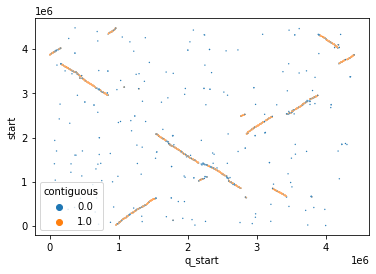

In [115]:
sns.scatterplot(data = test, x = 'q_start', y = 'start', s=2, hue = 'contiguous')

In [134]:
coverage = pd.DataFrame(blast_results_TB_genes_df.groupby('q_locus_tag').size()).reset_index()
coverage.columns = [['locus_tag','cover']]
temp = blast_results_TB_genes_df[blast_results_TB_genes_df.contiguous == 1]
contiguous_coverage = pd.DataFrame(temp.groupby('q_locus_tag').size()).reset_index()
contiguous_coverage.columns = [['locus_tag','cover']]

<AxesSubplot:ylabel='Count'>

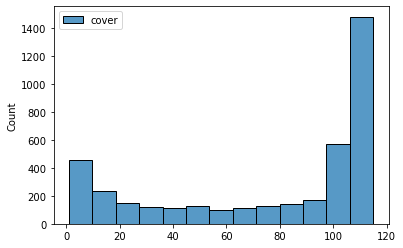

In [135]:
sns.histplot(coverage['cover'])

<AxesSubplot:ylabel='Count'>

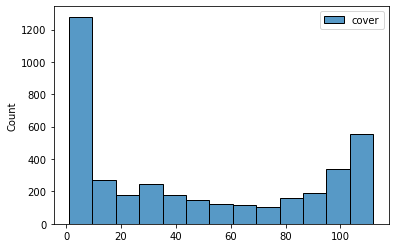

In [136]:
sns.histplot(contiguous_coverage['cover'])

In [122]:
coverage.to_csv(project_dir + '/coverage.csv')

In [ ]:
blast_results_TB_genes_df.organism.unique()

In [ ]:
test.to_csv(project_dir + '/test_blast_df.csv')

In [ ]:
#makeblastdb -in all_myco_refseq.fasta -dbtype prot -parse_seqids -out myco_refseq

In [126]:
pd.DataFrame(blast_results_TB_genes_df.groupby('q_locus_tag').size()).reset_index()

,q_locus_tag,0
0,RV1984a,78
1,Rv0001,110
2,Rv0002,110
3,Rv0003,110
4,Rv0004,108
...,...,...
3891,Rv3920c,110
3892,Rv3921c,110
3893,Rv3922c,101
3894,Rv3923c,109


In [128]:
coverage

,locus_tag,cover
0,RV1984a,78
1,Rv0001,110
2,Rv0002,110
3,Rv0003,110
4,Rv0004,108
...,...,...
3891,Rv3920c,110
3892,Rv3921c,110
3893,Rv3922c,101
3894,Rv3923c,109
